In [28]:
import pandas as pd
import numpy as np
import gc
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dftrain = pd.read_csv('datasources/jigsaw1/train.csv')
dftest = pd.read_csv('datasources/jigsaw1/test.csv')

In [3]:
dftrain['comment_text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [4]:
dftest['comment_text'].head()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

In [6]:
def clean_comments(df):
    comments = []
    for cmt in tqdm(df['comment_text']):
        #suppression des espace et caractères non-alphabetic characters
        comment_text = re.sub("[^a-zA-Z]"," ", cmt)
        comment_text = re.sub(' +', ' ', comment_text.strip())

        comments.append(comment_text)

    return(comments)
#clean comments for both train and test set
train_comments = clean_comments(dftrain)
test_comments = clean_comments(dftest)

100%|██████████| 153164/153164 [00:06<00:00, 22831.19it/s]


In [9]:
train_comments[0:6]

['Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now',
 'D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC',
 'Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info',
 'More I can t make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There ap

In [15]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_example = get_stemmed_text(train_comments[0:6])

In [16]:
stemmed_example[0]

'explan whi the edit made under my usernam hardcor metallica fan were revert they weren t vandal just closur on some ga after I vote at new york doll fac and pleas don t remov the templat from the talk page sinc I m retir now'

In [10]:
def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_example = get_lemmatized_text(train_comments[0:6])

In [11]:
lemmatized_example[0]

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'

In [20]:
len(lemmatized_example[0]), len(train_comments[0]), len(stemmed_example[0])

(247, 248, 224)

In [22]:
train_comments = get_stemmed_text(train_comments)
test_comments = get_stemmed_text(test_comments)

RecursionError: maximum recursion depth exceeded in comparison

In [25]:
train_comments[0], len(train_comments[0])

('Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now',
 248)

In [23]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words= 'english',
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 4),
    max_features=40000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=40000)

vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=3)

In [26]:
train_comments = dftrain['comment_text']
test_comments = dftest['comment_text']

vectorizer.fit(train_comments)

train_features = vectorizer.transform(train_comments)
test_features = vectorizer.transform(test_comments)

In [172]:
#np.array(train_features[:1,:])
np.printoptions(precision=2)
print(train_features[:5,:])

  (0, 654)	0.18518477557976915
  (0, 768)	0.14392588830650893
  (0, 849)	0.1643334147643378
  (0, 1095)	0.1728115494843725
  (0, 6827)	0.2007794389275949
  (0, 11058)	0.23201185926469764
  (0, 11080)	0.07377435735121228
  (0, 11081)	0.07391298624477385
  (0, 11185)	0.19628001497619127
  (0, 11944)	0.09489045696328269
  (0, 12871)	0.13361218689979462
  (0, 13019)	0.17334633474358424
  (0, 13317)	0.14864308471155907
  (0, 14647)	0.1780222345843142
  (0, 15728)	0.19628001497619127
  (0, 18515)	0.06959630598548991
  (0, 20715)	0.07886015637656749
  (0, 21837)	0.22529411779461564
  (0, 22788)	0.0932457900582783
  (0, 22851)	0.1519678221839016
  (0, 24214)	0.06416253973674155
  (0, 24467)	0.16877545046116502
  (0, 28451)	0.10652835077730763
  (0, 28492)	0.22145743304080487
  (0, 28969)	0.17813264268141152
  :	:
  (4, 74988)	0.06494035649289945
  (4, 75524)	0.02449891757435631
  (4, 75575)	0.03597897402561856
  (4, 75581)	0.039822842794683885
  (4, 76332)	0.03890411771233308
  (4, 76334)	0.03

In [128]:
train_features.shape

(159571, 80000)

In [154]:
train_features[]

SyntaxError: invalid syntax (<ipython-input-154-27000208cff4>, line 1)

In [129]:
#target_col = ['toxic', 'severe_toxic']
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

@@@@ Column :  toxic


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class toxic is 0.9789501603412607
Accuracy : 0.9608

Confusion matrix
 [[35786   240]
 [ 1322  2545]]


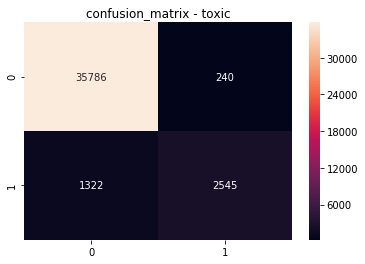


Classification_report
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     36026
           1       0.91      0.66      0.77      3867

   micro avg       0.96      0.96      0.96     39893
   macro avg       0.94      0.83      0.87     39893
weighted avg       0.96      0.96      0.96     39893

@@@@ Column :  severe_toxic


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class severe_toxic is 0.9884869196782657
Accuracy : 0.9897

Confusion matrix
 [[39372    66]
 [  345   110]]


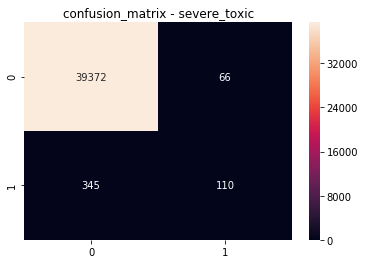


Classification_report
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     39438
           1       0.62      0.24      0.35       455

   micro avg       0.99      0.99      0.99     39893
   macro avg       0.81      0.62      0.67     39893
weighted avg       0.99      0.99      0.99     39893

@@@@ Column :  obscene


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class obscene is 0.9905562801901466
Accuracy : 0.9800

Confusion matrix
 [[37621   131]
 [  667  1474]]


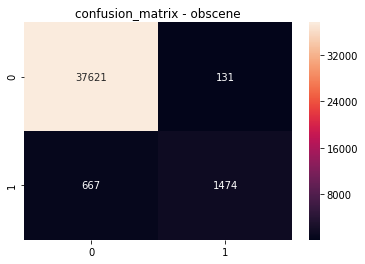


Classification_report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     37752
           1       0.92      0.69      0.79      2141

   micro avg       0.98      0.98      0.98     39893
   macro avg       0.95      0.84      0.89     39893
weighted avg       0.98      0.98      0.98     39893

@@@@ Column :  threat


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class threat is 0.9883719904043883
Accuracy : 0.9974

Confusion matrix
 [[39765     7]
 [   97    24]]


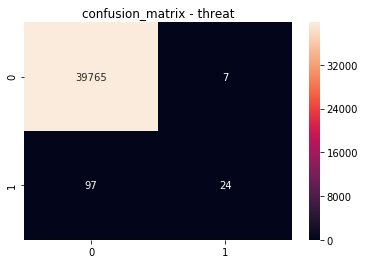


Classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39772
           1       0.77      0.20      0.32       121

   micro avg       1.00      1.00      1.00     39893
   macro avg       0.89      0.60      0.66     39893
weighted avg       1.00      1.00      1.00     39893

@@@@ Column :  insult


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class insult is 0.98303730803017
Accuracy : 0.9727

Confusion matrix
 [[37721   250]
 [  840  1082]]


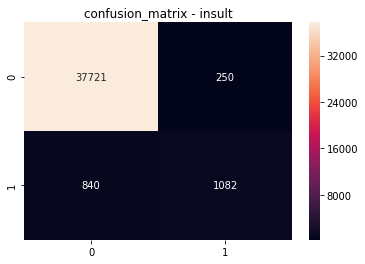


Classification_report
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     37971
           1       0.81      0.56      0.67      1922

   micro avg       0.97      0.97      0.97     39893
   macro avg       0.90      0.78      0.83     39893
weighted avg       0.97      0.97      0.97     39893

@@@@ Column :  identity_hate


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV score for class identity_hate is 0.9829629235204601
Accuracy : 0.9924

Confusion matrix
 [[39510    35]
 [  268    80]]


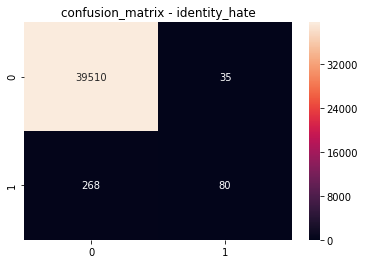


Classification_report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39545
           1       0.70      0.23      0.35       348

   micro avg       0.99      0.99      0.99     39893
   macro avg       0.84      0.61      0.67     39893
weighted avg       0.99      0.99      0.99     39893

Total CV score is 0.9853942636941152


In [130]:

auc_data ={"column0": ['frp','trp']}
scores = []
for class_name in target_col:
    print("@@@@ Column : ",class_name)
    train_target = dftrain[class_name]
    X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, train_size = 0.75)
    
    clf_LR = LogisticRegression(C=1, solver='sag')
    cv_score_LR = np.mean(cross_val_score(clf_LR, 
                                       X_train, 
                                       y_train, 
                                       cv=5, 
                                       scoring='roc_auc'))
    scores.append(cv_score_LR)
    print('CV score for class {} = {}'.format(class_name, cv_score))

    clf_LR.fit(X_train, y_train)
    
    y_pred =  clf_LR.predict(X_test)
    pred_pro =     clf_LR.predict_proba(X_test)[:,1]
    print('Accuracy : {:.4f}'.format(clf_LR.score(X_test, y_test)))
    print('\nConfusion matrix\n',confusion_matrix(y_test,y_pred))
    ax = plt.axes()
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d')
    ax.set_title('confusion_matrix - {}'.format(class_name))
    plt.show()
    print('\nClassification_report\n', classification_report(y_test,y_pred))
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    frp,trp,thres = roc_curve(y_test,pred_pro)
    auc_data[class_name] = [frp,trp]

print('Total CV score is {}'.format(np.mean(scores)))



In [131]:
df = pd.DataFrame(auc_data)
df

,column0,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,frp,"[0.0, 0.0, 0.0, 2.7757730527952033e-05, 2.7757...","[0.0, 0.0, 0.0, 2.535625538820427e-05, 2.53562...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.6488662852299217e-...","[0.0, 0.0, 0.0, 5.0286633812732576e-05, 5.0286...","[0.0, 0.0, 0.0, 2.6335887914461036e-05, 2.6335...","[0.0, 0.0, 0.0, 2.5287646984448096e-05, 2.5287..."
1,trp,"[0.0, 0.0002585983966899405, 0.225239203516938...","[0.0, 0.002197802197802198, 0.0043956043956043...","[0.0, 0.00046707146193367583, 0.03035964502568...","[0.0, 0.008264462809917356, 0.0661157024793388...","[0.0, 0.0005202913631633715, 0.040582726326742...","[0.0, 0.0028735632183908046, 0.008620689655172..."


In [118]:
df.columns[1]

'toxic'

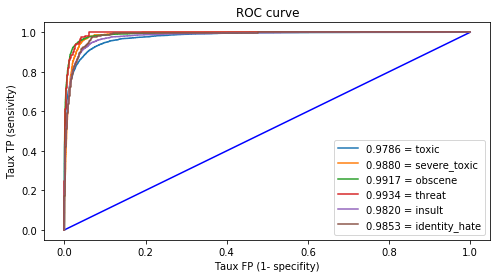

In [148]:

plt.figure(figsize=(8,4))
plt.plot([0,1],[0,1],color='b')
for class_name in target_col:
    plt.plot(df[class_name][0],
             df[class_name][1],
             label= '{:.4f} = {}'.format(auc(df[class_name][0],df[class_name][1]), class_name))
    plt.legend(loc='best')
    plt.xlabel('Taux FP (1- specifity)')
    plt.ylabel('Taux TP (sensivity)')
    plt.title('ROC curve')
plt.show()

In [157]:
x = pd.DataFrame(X_train)

In [158]:
x.head()

,0
0,"(0, 79477)\t0.04036415142184332\n (0, 79466..."
1,"(0, 77861)\t0.05905932697088931\n (0, 77860..."
2,"(0, 79564)\t0.04061385480279679\n (0, 79561..."
3,"(0, 79127)\t0.0428247802918464\n (0, 79124)..."
4,"(0, 79120)\t0.06356910870144579\n (0, 79118..."


In [ ]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [90]:
auc_data ={
  "column0": ['frp','trp']
}
auc_data["column1"] = [19,64]
print(auc_data)

{'column0': ['frp', 'trp'], 'column1': [19, 64]}


In [91]:
df = pd.DataFrame(auc_data)

In [92]:
df

,column0,column1
0,frp,19
1,trp,64


In [93]:
df['column1'][0], df['column1'][1]

(19, 64)